In [1]:
import gym
import torch
from darc import DARC
from sac import ContSAC
from broken_joint import BrokenJointEnv
import matplotlib.pyplot as plt
import numpy as np
from utils import *

env_name = 'HalfCheetah-v2'
source_env = BrokenJointEnv(gym.make(env_name), [0])
target_env = gym.make(env_name)

state_dim = source_env.observation_space.shape[0]
action_dim = source_env.action_space.shape[0]
print('state dim is: {} and action dim is: {}'.format(state_dim, action_dim))

device = 'cuda'

state dim is: 17 and action dim is: 6


In [2]:
policy_config = {
    "input_dim": [state_dim],
    "architecture": [{"name": "linear1", "size": 256},
                     {"name": "linear2", "size": 256},
                     {"name": "split1", "sizes": [action_dim, action_dim]}],
    "hidden_activation": "relu",
    "output_activation": "none"
}
value_config = {
    "input_dim": [state_dim + action_dim],
    "architecture": [{"name": "linear1", "size": 256},
                     {"name": "linear2", "size": 256},
                     {"name": "linear2", "size": 1}],
    "hidden_activation": "relu",
    "output_activation": "none"
}
sa_config = {
    "input_dim": [state_dim + action_dim],
    "architecture": [{"name": "linear1", "size": 64},
                     {"name": "linear3", "size": 2}],
    "hidden_activation": "relu",
    "output_activation": "none"
}
sas_config = {
    "input_dim": [state_dim * 2 + action_dim],
    "architecture": [{"name": "linear1", "size": 64},
                     {"name": "linear3", "size": 2}],
    "hidden_activation": "relu",
    "output_activation": "none"
}

# broken source

In [3]:
env_name = 'HalfCheetah-v2'
source_env = BrokenJointEnv(gym.make(env_name), [0])
target_env = gym.make(env_name)

state_dim = source_env.observation_space.shape[0]
action_dim = source_env.action_space.shape[0]
print('state dim is: {} and action dim is: {}'.format(state_dim, action_dim))

state dim is: 17 and action dim is: 6


In [4]:
# set current device
torch.cuda.set_device(0)
device = 'cuda'

In [5]:
running_state = ZFilter((state_dim,), clip=10)
model = DARC(policy_config, value_config, sa_config, sas_config, source_env, target_env, "cuda", ent_adj=True,
             n_updates_per_train=1,lr=3e-4,max_steps=200,batch_size=256,
             savefolder='broken_source_half_cheetah_200steps',running_mean=running_state,if_normalize = True)

src, tgt = model.train(5000, deterministic=False)

TARGET: index: 0, steps: 201, total_rewards: -80.63218458557819
SOURCE: index: 0, steps: 201, total_rewards: -1.5736010596478547
TARGET: index: 1, steps: 201, total_rewards: -28.342642422418376
SOURCE: index: 1, steps: 201, total_rewards: -45.84491772220702
TARGET: index: 2, steps: 201, total_rewards: -141.66150369044362
SOURCE: index: 2, steps: 201, total_rewards: -12.636812003479235
TARGET: index: 3, steps: 201, total_rewards: -47.79673587894957
SOURCE: index: 3, steps: 201, total_rewards: -62.6445943617955
TARGET: index: 4, steps: 201, total_rewards: -78.83976467193577
SOURCE: index: 4, steps: 201, total_rewards: -66.2588354403608
TARGET: index: 5, steps: 201, total_rewards: -39.51758700812627
SOURCE: index: 5, steps: 201, total_rewards: -68.36369578097465
TARGET: index: 6, steps: 201, total_rewards: 20.820630343365654
SOURCE: index: 6, steps: 201, total_rewards: -10.962544741283875
TARGET: index: 7, steps: 201, total_rewards: -82.66050482958602
SOURCE: index: 7, steps: 201, total_r

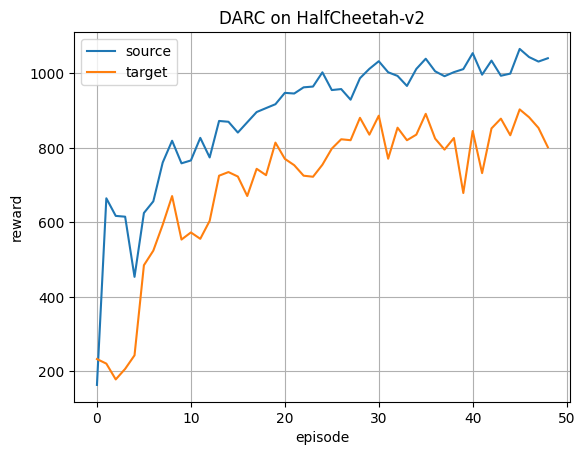

In [6]:
length = list(range(len(src)))
plt.plot(length, src, label="source")
plt.plot(length, tgt, label="target")
plt.xlabel("episode")
plt.ylabel("reward")
plt.title("DARC on HalfCheetah-v2")
plt.legend()
plt.grid()
plt.show()

# Sample Expert trajectory and save

In [9]:
import gym
import argparse
import numpy as np
from darc import DARC
from broken_joint import BrokenJointEnv
import os
import torch
from utils import *
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

import sys
import pickle
import time
from src_gailsac_classifier import GailContSAC_SRC_Classifier

In [10]:
render = 'store_true'
log_std = -0.0
gamma = 0.99
tau = 0.95
lr_reg = 1e-3
learning_rate = 5e-5
clip_epsilon = 0.01
num_threads = 1
seed = 1
min_batch_size = 2048
eval_batch_size = 2048
max_iter_num = 15000
log_interval = 1
save_model_path = ''
max_expert_state_num = 1000
train_steps = 2000
episode_length = 200
save_file_name = ''
optim_epochs = 3


env_name = "HalfCheetah-v2"
env = gym.make(env_name)

def lr_decay(actor_optim,cirtic_optim, total_steps,max_steps):
    if total_steps > 7000:
        lr_a_now = learning_rate * (1 - (total_steps-7000) /(max_steps))
        for p in actor_optim.param_groups:
            p['lr'] = lr_a_now
        for p in cirtic_optim.param_groups:
            p['lr'] = lr_a_now
    return actor_optim,cirtic_optim



In [11]:
save_model = 'broken_source_half_cheetah_200steps/4900'


expert_model = DARC(policy_config, value_config, sa_config, sas_config, source_env, target_env, device, ent_adj=True,
             n_updates_per_train=1, max_steps = 200, batch_size=256, savefolder ='none') 
expert_model.load_model(save_model, device)
expert_model.running_mean.fix = True


In [13]:
num_steps = 0
expert_traj = []
total_reward = 0
from tqdm import tqdm

for i_episode in tqdm(range(100000)):

    state = source_env.reset()
    state = expert_model.running_mean(state)
    reward_episode = 0

    for t in range(episode_length):
        action = expert_model.get_action(state, deterministic=True)
        next_state, reward, done, _ = source_env.step(action)
        next_state = expert_model.running_mean(next_state)
        reward_episode += reward
        num_steps += 1

        expert_traj.append(np.hstack([state, next_state]))
        

        if done or num_steps >= max_expert_state_num:
            break


        state = next_state
    if num_steps >= max_expert_state_num:
        break
    total_reward += reward_episode

    # print('Episode {}\t reward: {:.2f} \t step : {}'.format(i_episode, reward_episode,t))
print('eval on src',total_reward/(i_episode))
expert_traj = np.stack(expert_traj)

total_reward = 0
num_steps = 0
for i_episode in tqdm(range(50)):
    state = target_env.reset()
    state = expert_model.running_mean(state)
    reward_episode = 0
    for t in range(episode_length):
        action = expert_model.get_action(state, deterministic=True)
        next_state, reward, done, _ = target_env.step(action)
        next_state = expert_model.running_mean(next_state)
        reward_episode += reward
        num_steps += 1
        if done or num_steps >= max_expert_state_num:
            break
        state = next_state
    if num_steps >= max_expert_state_num:
        break
    total_reward += reward_episode
print('eval on tgt',total_reward/(i_episode))

  0%|          | 4/100000 [00:00<3:36:55,  7.68it/s]


eval on src 1178.3674280024952


  8%|▊         | 4/50 [00:00<00:05,  7.83it/s]

eval on tgt 1157.5702345643874


In [14]:
IL = GailContSAC_SRC_Classifier(policy_config, value_config,  source_env, target_env, device, expert_traj, expert_model, ent_adj=True, n_updates_per_train=1,gamma = 0.99,
                 batch_size=256,lr = 3e-4, max_steps = 200, running_mean=expert_model.running_mean,
                            warmup_games=50, eval_step = False,
                                noise_scale = 1e-4, update_freq = 50,
                                    if_normalize=True, clamp_reward_lower_bound = 0.1, clamp_reward_upper_bound = 10,
                               reward_type = 2)

src_bs, tgt_bs, classifier_loss = IL.train(5000, deterministic=False)


index: 0, steps: 201, total_rewards: 30.726666669739817, total_reward_adv: -26.0691, acc gen: 0, acc expert: 0
eval reward: -0.3775722576371314
index: 1, steps: 201, total_rewards: -1.7503328539422052, total_reward_adv: -306.8765, acc gen: 0, acc expert: 0
index: 2, steps: 201, total_rewards: -30.109691891439727, total_reward_adv: -102.3157, acc gen: 0, acc expert: 0
index: 3, steps: 201, total_rewards: 6.082047173240307, total_reward_adv: -42.521, acc gen: 0, acc expert: 0
index: 4, steps: 201, total_rewards: -40.23598528301177, total_reward_adv: -107.1745, acc gen: 0, acc expert: 0
index: 5, steps: 201, total_rewards: -105.37163580515997, total_reward_adv: -201.229, acc gen: 0, acc expert: 0
index: 6, steps: 201, total_rewards: -49.397714123593005, total_reward_adv: -124.3034, acc gen: 0, acc expert: 0
index: 7, steps: 201, total_rewards: 25.277326172353597, total_reward_adv: -17.4237, acc gen: 0, acc expert: 0
index: 8, steps: 201, total_rewards: -56.00676389971206, total_reward_adv

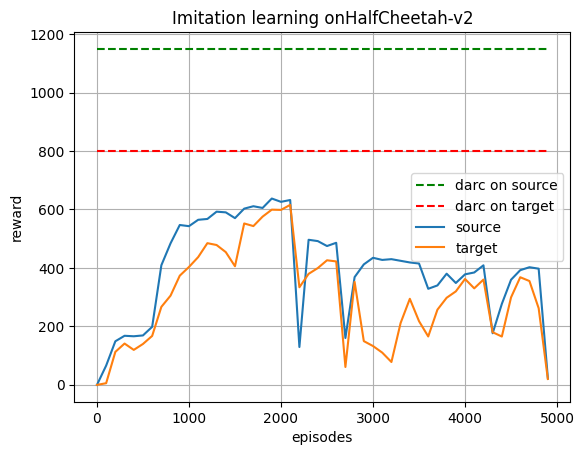

In [15]:
length = np.array(list(range(len(src_bs)))) * 100
darc_source = np.ones_like(length) * 1150
darc_target = np.ones_like(length) * 800

plt.plot(length, darc_source, 'g--', label='darc on source')
plt.plot(length, darc_target, 'r--', label='darc on target')
plt.plot(length, src_bs, label="source")
plt.plot(length, tgt_bs, label="target")
plt.xlabel("episodes")
plt.ylabel("reward")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


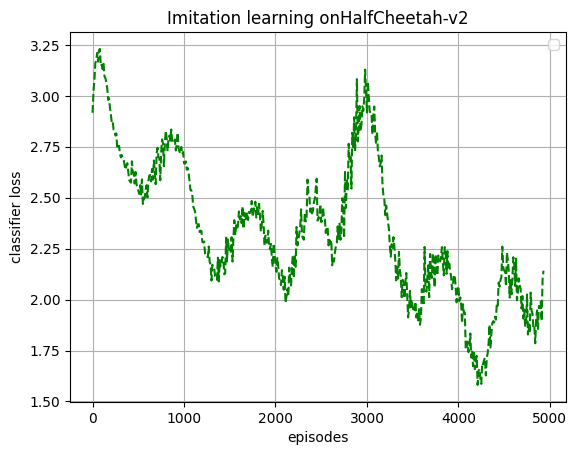

In [16]:
loss_length = np.array(list(range(len(classifier_loss)))) * 10
plt.plot(loss_length, classifier_loss, 'g--')

plt.xlabel("episodes")
plt.ylabel("classifier loss")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

In [17]:
IL_2 = GailContSAC_SRC_Classifier(policy_config, value_config,  source_env, target_env, device, expert_traj, expert_model, ent_adj=True, n_updates_per_train=1,gamma = 0.99,
                 batch_size=256,lr = 3e-4, max_steps = 200, running_mean=expert_model.running_mean,
                            warmup_games=50, eval_step = False,
                                noise_scale = 1e-4, update_freq = 50,
                                    if_normalize=True, clamp_reward_lower_bound = 0.5, clamp_reward_upper_bound = 2,
                               reward_type = 2)

src_bs_2, tgt_bs_2, classifier_loss_2 = IL_2.train(5000, deterministic=False)


index: 0, steps: 201, total_rewards: -55.506127054040974, total_reward_adv: -102.0043, acc gen: 0, acc expert: 0
eval reward: -0.7077809049410669
index: 1, steps: 201, total_rewards: -13.805905686827396, total_reward_adv: -20.2166, acc gen: 0, acc expert: 0
index: 2, steps: 201, total_rewards: -28.18200116655918, total_reward_adv: -32.3356, acc gen: 0, acc expert: 0
index: 3, steps: 201, total_rewards: -71.24086126814848, total_reward_adv: -77.1265, acc gen: 0, acc expert: 0
index: 4, steps: 201, total_rewards: -40.85133220046424, total_reward_adv: -46.6449, acc gen: 0, acc expert: 0
index: 5, steps: 201, total_rewards: -46.96071160659663, total_reward_adv: -55.5764, acc gen: 0, acc expert: 0
index: 6, steps: 201, total_rewards: -16.713775285136848, total_reward_adv: -26.0695, acc gen: 0, acc expert: 0
index: 7, steps: 201, total_rewards: -10.858427078762883, total_reward_adv: -14.4038, acc gen: 0, acc expert: 0
index: 8, steps: 201, total_rewards: -75.9978542213913, total_reward_adv: 

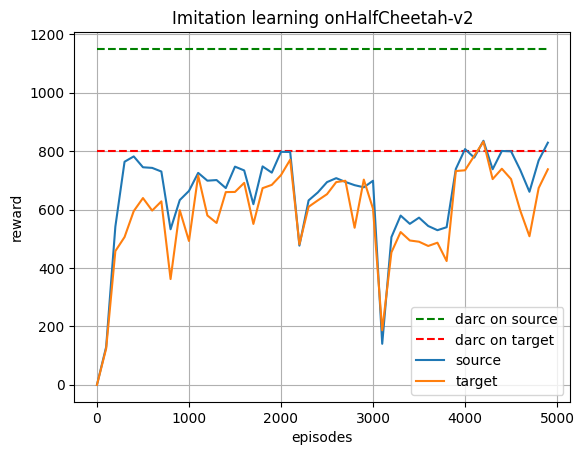

In [18]:
length = np.array(list(range(len(src_bs_2)))) * 100
darc_source = np.ones_like(length) * 1150
darc_target = np.ones_like(length) * 800

plt.plot(length, darc_source, 'g--', label='darc on source')
plt.plot(length, darc_target, 'r--', label='darc on target')
plt.plot(length, src_bs_2, label="source")
plt.plot(length, tgt_bs_2, label="target")
plt.xlabel("episodes")
plt.ylabel("reward")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


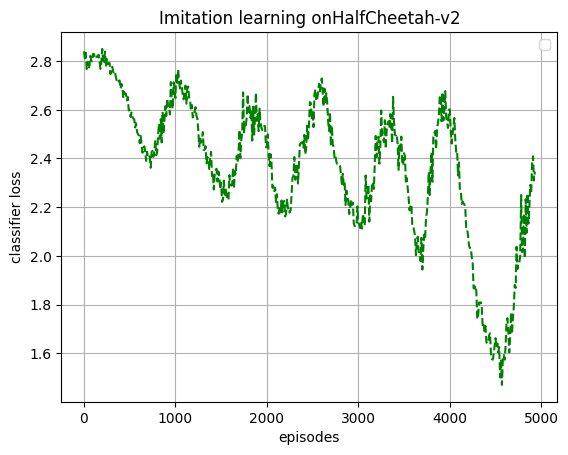

In [19]:
loss_length_2 = np.array(list(range(len(classifier_loss_2)))) * 10
plt.plot(loss_length_2, classifier_loss_2, 'g--')

plt.xlabel("episodes")
plt.ylabel("classifier loss")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

In [21]:
IL_3 = GailContSAC_SRC_Classifier(policy_config, value_config,  source_env, target_env, device, expert_traj, expert_model, ent_adj=True, n_updates_per_train=1,gamma = 0.99,
                 batch_size=256,lr = 5e-5, max_steps = 200, running_mean=expert_model.running_mean,
                            warmup_games=50, eval_step = False,
                                noise_scale = 1e-4, update_freq = 100,
                                    if_normalize=True, clamp_reward_lower_bound = 0.1, 
                                    clamp_reward_upper_bound = 10,
                               reward_type = 2)

src_bs_3, tgt_bs_3, classifier_loss_3 = IL_3.train(5000, deterministic=False)


index: 0, steps: 201, total_rewards: -16.808891518716504, total_reward_adv: -46.3535, acc gen: 0, acc expert: 0
eval reward: -0.3946021891005014
index: 1, steps: 201, total_rewards: -8.201520393026758, total_reward_adv: -115.3298, acc gen: 0, acc expert: 0
index: 2, steps: 201, total_rewards: -75.09758478573806, total_reward_adv: -113.4907, acc gen: 0, acc expert: 0
index: 3, steps: 201, total_rewards: -37.95584617780534, total_reward_adv: -64.9382, acc gen: 0, acc expert: 0
index: 4, steps: 201, total_rewards: -37.324815527470946, total_reward_adv: -69.6538, acc gen: 0, acc expert: 0
index: 5, steps: 201, total_rewards: -7.333105360496206, total_reward_adv: -87.4348, acc gen: 0, acc expert: 0
index: 6, steps: 201, total_rewards: -16.349681273259645, total_reward_adv: -50.8644, acc gen: 0, acc expert: 0
index: 7, steps: 201, total_rewards: -18.428667985574872, total_reward_adv: -44.9725, acc gen: 0, acc expert: 0
index: 8, steps: 201, total_rewards: -73.6782095217105, total_reward_adv:

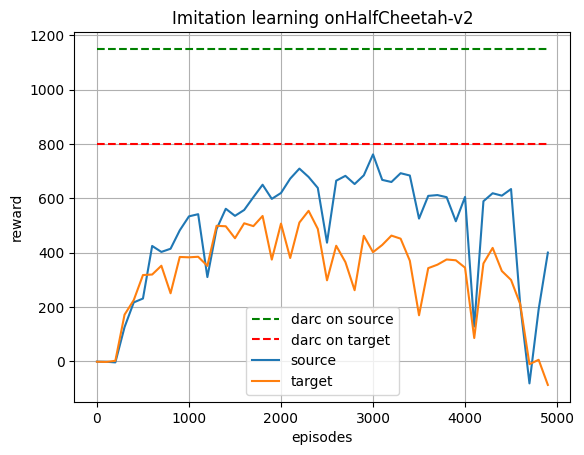

In [23]:
length = np.array(list(range(len(src_bs_3)))) * 100
darc_source = np.ones_like(length) * 1150
darc_target = np.ones_like(length) * 800

plt.plot(length, darc_source, 'g--', label='darc on source')
plt.plot(length, darc_target, 'r--', label='darc on target')
plt.plot(length, src_bs_3, label="source")
plt.plot(length, tgt_bs_3, label="target")
plt.xlabel("episodes")
plt.ylabel("reward")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


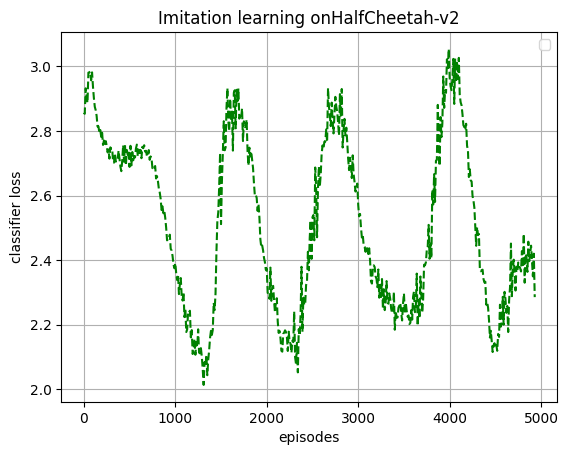

In [22]:
loss_length_3 = np.array(list(range(len(classifier_loss_3)))) * 10
plt.plot(loss_length_3, classifier_loss_3, 'g--')

plt.xlabel("episodes")
plt.ylabel("classifier loss")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

In [23]:
IL_4 = GailContSAC_SRC_Classifier(policy_config, value_config,  source_env, target_env, device, expert_traj, expert_model, ent_adj=True, n_updates_per_train=1,gamma = 0.99,
                 batch_size=256,lr = 5e-5, max_steps = 200, running_mean=expert_model.running_mean,
                            warmup_games=50, eval_step = False,
                                noise_scale = 1e-4, update_freq = 10,
                                    if_normalize=True, clamp_reward_lower_bound = 0.1, 
                                    clamp_reward_upper_bound = 10,
                               reward_type = 2)

src_bs_4, tgt_bs_4, classifier_loss_4 = IL_4.train(5000, deterministic=False)


index: 0, steps: 201, total_rewards: -63.69695082995994, total_reward_adv: -3.3891, acc gen: 0, acc expert: 0
eval reward: -0.20284676009701844
index: 1, steps: 201, total_rewards: -55.97335882900075, total_reward_adv: 8.0876, acc gen: 0, acc expert: 0
index: 2, steps: 201, total_rewards: -57.509436328185856, total_reward_adv: -5.7779, acc gen: 0, acc expert: 0
index: 3, steps: 201, total_rewards: -65.88127599128804, total_reward_adv: -10.7726, acc gen: 0, acc expert: 0
index: 4, steps: 201, total_rewards: 6.8453094243515995, total_reward_adv: 44.1889, acc gen: 0, acc expert: 0
index: 5, steps: 201, total_rewards: -57.84011401392815, total_reward_adv: -7.5273, acc gen: 0, acc expert: 0
index: 6, steps: 201, total_rewards: -55.47712949808745, total_reward_adv: -1.0729, acc gen: 0, acc expert: 0
index: 7, steps: 201, total_rewards: -39.59486053538327, total_reward_adv: 8.6594, acc gen: 0, acc expert: 0
index: 8, steps: 201, total_rewards: -96.28480268181347, total_reward_adv: -30.4773, a

In [ ]:
length = np.array(list(range(len(src_bs_4)))) * 100
darc_source = np.ones_like(length) * 1150
darc_target = np.ones_like(length) * 800

plt.plot(length, darc_source, 'g--', label='darc on source')
plt.plot(length, darc_target, 'r--', label='darc on target')
plt.plot(length, src_bs_4, label="source")
plt.plot(length, tgt_bs_4, label="target")
plt.xlabel("episodes")
plt.ylabel("reward")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()

In [ ]:
loss_length_4 = np.array(list(range(len(classifier_loss_4)))) * 10
plt.plot(loss_length_4, classifier_loss_4, 'g--')

plt.xlabel("episodes")
plt.ylabel("classifier loss")
plt.title("Imitation learning on{}".format(env_name))
plt.legend()
plt.grid()
plt.show()